In [1]:
import umap
import phenograph
from scipy import stats

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm
from scipy import sparse
from sklearn import cluster, preprocessing, decomposition

from meshparty import meshwork, trimesh_vtk
from caveclient import CAVEclient

from common_setup import project_info, project_paths
import plotting_code
import feature_clustering as fc
import tqdm

def relabel_sorted(df, label_column, sort_column, ascending=True):
    sorted_label = (
        df.groupby(label_column)
        .agg({sort_column: "mean"})
        .sort_values(by=sort_column, ascending=ascending)
        .index.values
    )
    relabel_index = {x: ii for ii, x in enumerate(sorted_label)}
    df[label_column] = df[label_column].apply(lambda x: relabel_index[x])

client = CAVEclient(project_info.datastack)
version = 795
timestamp = client.materialize.get_timestamp(version=version)

sk_dir = f"{project_paths.skeletons}/skeleton_files"
base_path = f"{project_paths.base}/pipelines"
height_bounds = np.load(f"{project_paths.data}/height_bounds_v1.npy")
width_bounds = np.load(f"{project_paths.data}/width_bounds_v1.npy")
layer_bounds = np.load(f"{project_paths.data}/layer_bounds_v3.npy")

feature_dir = f"{project_paths.data}/features/features_feb7"

data_dir = f'paper_versions/v{version}/data'
plot_dir = f'paper_versions/v{version}/plots'
plot_data_dir = f"{plot_dir}/associated_data"

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

if not os.path.exists(plot_data_dir):
    os.makedirs(plot_data_dir)

height_bounds = height_bounds - height_bounds[0]

In [2]:
layer_bounds

array([ 91.80615154, 261.21908419, 391.8631847 , 537.04973966,
       753.58049474])

In [3]:
height_bounds

array([  0.   , 950.112])

In [2]:
import palettable

ei_palette = {
    'Inh': sns.color_palette('Greens', n_colors=5)[3],
    'Exc':sns.color_palette('BuPu', n_colors=5)[4],
}

In [4]:
ct_df = client.materialize.query_table(project_info.slant_table, timestamp=timestamp)

unsure_idx = ct_df.query('classification_system == "aibs_coarse_unclear"').index
ct_df.drop(unsure_idx, inplace=True)

e_oids = ct_df.query('classification_system == "aibs_coarse_excitatory"')[
    "pt_root_id"
].values

i_oids = ct_df.query('classification_system == "aibs_coarse_inhibitory"')[
    "pt_root_id"
].values

In [ ]:
all_oids = np.concatenate((e_oids, i_oids))

rerun=False

root_id_extracted = fc.extraction.extract_features_mp(
    all_oids, project_paths, feature_dir, rerun
)

print(f"Failed: {all_oids[np.array(root_id_extracted)==False]}")
# No failures expected

In [ ]:
raw_df = fc.io_utils.load_features(e_oids, feature_dir)
(
    feat_df,
    feat_cols,
    syn_pca,
    br_svd,
    keep_depth,
    ego_pca,
) = fc.assembly.assemble_features_from_data(raw_df, n_syn_comp=6, n_branch_comp=3, n_syn_ego=5)

In [ ]:
ego_bins = np.linspace(-100, 100, 13)

In [ ]:
save_figures = True

radius_bins = fc.extraction.radius_bins
depth_bins = fc.extraction.make_depth_bins(height_bounds, 50)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), facecolor="w")

ax = axes[0]
pca_colors = palettable.colorbrewer.qualitative.Dark2_6.mpl_colors
for x, c in zip(syn_pca.components_, pca_colors):
    ax.plot(x, depth_bins[:-1][keep_depth], linewidth=2, alpha=0.75, color=c)
    plotting_code.plot_layers(
        layer_bounds,
        height_bounds,
        ax.get_xlim(),
        color=(0.5, 0.5, 0.5),
        linewidth=1,
        linestyle=":",
        ax=ax,
    )
    sns.despine(ax=ax)
    ax.set_title("Synapse depth components")

ax = axes[1]
svd_colors = palettable.colorbrewer.sequential.Blues_9_r.mpl_colors[::2]

for x, c in zip(br_svd.components_, svd_colors):
    ax.plot(radius_bins, x, color=c)
sns.despine(ax=ax)
ax.set_title("Branch radius components")
_ = ax.set_xlabel("Distance from soma ($\mu m$)")

ax = axes[2]
ego_colors = palettable.colorbrewer.qualitative.Set3_10.mpl_colors

for x, c in zip(ego_pca.components_, ego_colors):
    ax.plot(x, ego_bins, color=c)
sns.despine(ax=ax)
ax.set_title("Egocentric synapse components")
_ = ax.set_ylabel("Vertical distance from soma ($\mu m$)")

plt.tight_layout()
if save_figures:
    fig.savefig(f"{plot_dir}/component_explanation_excitatory.pdf", bbox_inches='tight')

In [ ]:
height_bounds

In [ ]:
save_figures = True

radius_bins = fc.extraction.radius_bins
depth_bins = fc.extraction.make_depth_bins(height_bounds, 50)

fig, axes = plt.subplots(ncols=len(syn_pca.components_), figsize=(2 * len(syn_pca.components_), 3), facecolor="w")
# pca_colors = palettable.colorbrewer.qualitative.Dark2_6.mpl_colors
for ii, (ax, x, c) in enumerate(zip(axes, syn_pca.components_, pca_colors)):
    ax.plot(x, depth_bins[:-1][keep_depth], linewidth=2, alpha=0.75, color='k')
    ax.set_xlim(-.50, .50)
    plotting_code.plot_layers(
        layer_bounds,
        height_bounds - np.array([0, 80]),
        ax.get_xlim(),
        color=(0.5, 0.5, 0.5),
        linewidth=1,
        linestyle=":",
        ax=ax,
    )
    ax.vlines(0, *ax.get_ylim(), color=(0.5, 0.5, 0.5), linestyle='--', zorder=-20)

    sns.despine(ax=ax)
    ax.set_title(f"Syn. Comp. {ii}")

plt.tight_layout()
if save_figures:
    fig.savefig(f"{plot_dir}/component_explanation_depth.pdf", bbox_inches='tight')

fig, axes = plt.subplots(ncols=len(br_svd.components_), figsize=(3 * len(br_svd.components_), 3), facecolor="w")
svd_colors = palettable.colorbrewer.sequential.Blues_9_r.mpl_colors
for ii, (ax, x, c) in enumerate(zip(axes, br_svd.components_, svd_colors)):
    ax.plot(radius_bins, x, linewidth=2, alpha=0.75, color='k')
    sns.despine(ax=ax)
    ax.set_ylim(-.65, .65)
    ax.hlines(0, *ax.get_xlim(), color=(0.5, 0.5, 0.5), linestyle='--', zorder=-20)
    ax.set_title(f"Branch Comp. {ii}")

plt.tight_layout()
if save_figures:
    fig.savefig(f"{plot_dir}/component_explanation_branches.pdf", bbox_inches='tight')

fig, axes = plt.subplots(ncols=len(ego_pca.components_), figsize=(2 * len(ego_pca.components_), 3), facecolor="w")
svd_colors = palettable.colorbrewer.sequential.Blues_9_r.mpl_colors
for ii, (ax, x, c) in enumerate(zip(axes, ego_pca.components_, svd_colors)):
    ax.plot(x, ego_bins, linewidth=2, alpha=0.75, color='k')
    sns.despine(ax=ax)
    ax.set_xlim(-.80, .80)
    ax.hlines(0, *ax.get_xlim(), color=(0.5, 0.5, 0.5), linestyle='--', zorder=-20)
    ax.set_title(f"Soma-centric Comp. {ii}")

plt.tight_layout()
if save_figures:
    fig.savefig(f"{plot_dir}/component_explanation_soma.pdf", bbox_inches='tight')

# if save_figures:
#     fig.savefig(f"{plot_dir}/component_explanation_depth.pdf", bbox_inches='tight')ax.set_xlim(-0.50, 0.50)

# ax = axes[1]
# svd_colors = palettable.colorbrewer.sequential.Blues_9_r.mpl_colors[::2]

# for x, c in zip(br_svd.components_, svd_colors):
#     ax.plot(radius_bins, x, color=c)
# sns.despine(ax=ax)
# ax.set_title("Branch radius components")
# _ = ax.set_xlabel("Distance from soma ($\mu m$)")

# ax = axes[2]
# ego_colors = palettable.colorbrewer.qualitative.Set3_10.mpl_colors

# for x, c in zip(ego_pca.components_, ego_colors):
#     ax.plot(x, ego_bins, color=c)
# sns.despine(ax=ax)
# ax.set_title("Egocentric synapse components")
# _ = ax.set_ylabel("Vertical distance from soma ($\mu m$)")



In [ ]:
dfct = feat_df.merge(
    ct_df[["pt_root_id", "classification_system", "cell_type"]],
    left_on="root_id",
    right_on="pt_root_id",
    how="left",
)

dfct_e = dfct.query('classification_system == "aibs_coarse_excitatory"').reset_index(
    drop=True
)

dat = dfct_e[feat_cols].values
datz = stats.zscore(dat)

res = umap.UMAP(
    metric="euclidean",
    min_dist=0.1,
    n_neighbors=20,
)
xx = res.fit_transform(datz)
dfct_e["umap0_raw"] = xx[:, 0]
dfct_e["umap1_raw"] = xx[:, 1]

### Cluster cells

First we inspect the values and the UMAP to see if it passes a sanity check

In [ ]:
# dfct_e2 = pd.read_feather(f"{data_dir}/dfct_e.feather")

# dfct_e2['umap0_raw'] = dfct_e['umap0_raw'] 
# dfct_e2['umap1_raw'] = dfct_e['umap1_raw'] 

# dfct_e.to_feather(f"{data_dir}/dfct_e_better_umap.feather")

In [ ]:
res_param = 1.3
kph = 10

dat = dfct_e[feat_cols].values
datz = stats.zscore(dat)

labels, G, Q = phenograph.cluster(
    datz,
    clustering_algo="leiden",
    k=kph,
    resolution_parameter=res_param,
)

dfct_e["hlabel"] = labels
relabel_sorted(dfct_e, "hlabel", "soma_depth")

fig, ax = plt.subplots(dpi=150)
sns.scatterplot(
    x=f"umap0_raw",
    y=f"umap1_raw",
    data=dfct_e,
    hue="hlabel",
    palette="tab20",
    s=10,
)
ax.set_aspect('equal')
ax.legend().set_bbox_to_anchor((1, 1))

dfct_e.pivot_table(
    values="umap0_raw",
    index="hlabel",
    columns="cell_type",
    aggfunc="count",
    fill_value=0,
)

In [ ]:
save_plots = True

fig, ax = plt.subplots(dpi=150, figsize=(6,6))
sns.scatterplot(
    x=f"umap0_raw",
    y=f"umap1_raw",
    data=dfct_e,
    hue="cell_type",
    palette="deep",
    # edgecolor='k',
    hue_order=['23P', '4P', '5P-IT', '5P-PT', '5P-NP', '6P-IT', '6P-CT', '6P-U', 'WM-P', 'Unsure E'],
    s=5,
)

ax.set_aspect('equal')

ax.legend().set_bbox_to_anchor((1, 1))
sns.despine(ax=ax, trim=True)
ax.set_xlabel("umap0")
ax.set_ylabel("umap1")
if save_plots:
    fig.savefig('plots/manual_cell_types_umap.pdf', bbox_inches='tight')

In [ ]:
ntimes = 200
hold_out = 0.95

res_param = 1.3
kph = 10

dat = dfct_e[feat_cols].values

df_groups = pd.DataFrame(index=dfct_e.index)
for ii in tqdm.tqdm(np.arange(ntimes)):
    subset_inds = np.sort(
        np.random.choice(
            np.arange(dat.shape[0]),
            size=np.round(hold_out * dat.shape[0]).astype(int),
            replace=False,
        )
    )
    # subset_inds = dfct_e.index
    dat_sub = dfct_e.loc[subset_inds][feat_cols].values
    
    datz = stats.zscore(dat_sub)

    labels, G, Q = phenograph.cluster(
        datz, clustering_algo="leiden", k=kph, resolution_parameter=res_param,
    )

    colname = f"r_k{kph}_{ii}"
    df_groups.loc[subset_inds, colname] = labels

# if save_plots:
# df_groups.to_pickle("df_groups_onehot_100_v5.pickle")

In [ ]:
def eq_nan_dist(u, v):
    no_nan = ~pd.isna(u + v)
    is_eq = np.equal(u[no_nan], v[no_nan])
    return is_eq.astype(int).sum()

from scipy import spatial

N_co = spatial.distance.pdist(df_groups, eq_nan_dist)
N_square = spatial.distance.squareform(N_co)

from sklearn import cluster, metrics

In [ ]:
n_cl = []
sils = []
dbscores=[]
for k in np.arange(2,30):
    n_cl.append(k)
    model = cluster.AgglomerativeClustering(
        n_clusters=k,
        affinity="precomputed",
        linkage="complete",
        compute_distances=True,
        compute_full_tree=True,
    )
    l = model.fit_predict(-N_square)
    sils.append(metrics.silhouette_score(N_square, l))
    dbscores.append(metrics.davies_bouldin_score(N_square, l))

In [ ]:
save_plots = False

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3), nrows=2, sharex=True)
rel_ind = 16
ax[0].plot(n_cl, dbscores, color='k')
ax[0].plot(n_cl[rel_ind], dbscores[rel_ind], 'ro')
ax[0].set_ylabel('Davies-Bouldin')

ax[1].plot(n_cl, sils, color='k')
ax[1].plot(n_cl[rel_ind], sils[rel_ind], 'ro')
ax[1].set_ylabel('Silhouette')
_ = ax[1].set_xticks(np.arange(0, 30, 5))

sns.despine(ax=ax[0])
sns.despine(ax=ax[1])

if save_plots:
    fig.savefig(f'plots/cluster_score.pdf', bbox_inches='tight')

In [ ]:
n_cl[rel_ind]

In [ ]:
ctype_hues = sns.color_palette('tab20', n_colors=n_cl[rel_ind])

In [ ]:
from sklearn.neighbors import kneighbors_graph

In [ ]:
model = cluster.AgglomerativeClustering(
    n_clusters=n_cl[rel_ind],
    affinity="precomputed",
    linkage="complete",
    compute_distances=True,
    compute_full_tree=True,
)

l = model.fit_predict(-N_square)

dfct_e["hlabel_int"] = l
relabel_sorted(dfct_e, "hlabel_int", "soma_depth")

fig, ax = plt.subplots(dpi=150)
sns.scatterplot(
    x=f"umap0_raw",
    y=f"umap1_raw",
    data=dfct_e,
    hue=f"hlabel_int",
    palette='tab20',
    s=4,
)
ax.set_aspect('equal')

ax.legend().set_bbox_to_anchor((1, 1))

dfct_e.pivot_table(
    values="umap0_raw",
    index=f"hlabel_int",
    columns="cell_type",
    aggfunc="count",
    fill_value=0,
)
ax.set_xlabel("umap0")
ax.set_xlabel("umap1")
sns.despine(ax=ax, trim=True)

In [ ]:
fig, ax = plt.subplots(figsize=(6,6), dpi=200)

sns.scatterplot(
    x='path_length_dendrite',
    y='soma_depth',
    hue='hlabel_int',
    palette='tab20',
    data=dfct_e,
    s=4,
    ax=ax,
    legend=None,
)

plotting_code.plot_layers(
    layer_bounds,
    span=ax.get_xlim(),
    depth_bounds=height_bounds,
    color=(0.5, 0.5, 0.5),
    linestyle=":",
    zorder=-10,
    ax=ax,
)


In [ ]:
fig, ax = plt.subplots(figsize=(5,4), dpi=150)
sns.swarmplot(
    x='hlabel_int',
    y='soma_depth',
    hue='hlabel_int',
    palette='tab20',
    data=dfct_e,
    s=1,
    ax=ax,
)
plotting_code.plot_layers(
    layer_bounds,
    span=ax.get_xlim(),
    depth_bounds=height_bounds,
    color=(0.5, 0.5, 0.5),
    linestyle=":",
    zorder=-10,
    ax=ax,
)
ax.legend().set_visible(False)

In [ ]:
dfct_e.query('hlabel_int == 11').sort_values(by='soma_depth')

In [ ]:
dfct_e.query('hlabel_int == 8').root_id.sample(10).values

12 short
13 tall
14 mixed but upright?
16 tallish
17 tall

In [ ]:
ct_table = dfct_e.pivot_table(
    values="umap0_raw",
    index=f"hlabel_int",
    columns="cell_type",
    aggfunc="count",
    fill_value=0,
)
ct_table

In [ ]:
e_types = [
    "L2a",
    "L2b",
    "L2c",
    "L3a",
    "L3b",
    "L4a",
    "L4b",
    "L4c",
    "L5a",
    "L5b",
    "L5ET",
    "L5NP",
    "L6short-a",
    "L6tall-a",
    "L6short-b",
    "L6tall-b",
    "L6tall-c",
    "L6wm",
]

e_types_ord = [
    "L2a",
    "L2b",
    "L2c",
    "L3a",
    "L3b",
    "L4a",
    "L4b",
    "L4c",
    "L5a",
    "L5b",
    "L5ET",
    "L5NP",
    "L6short-a",
    "L6short-b",
    "L6tall-a",
    "L6tall-b",
    "L6tall-c",
    "L6wm",
]

dfct_e["hlabel"] = (
    dfct_e["hlabel_int"]
    .replace({ii: ct for ii, ct in enumerate(e_types)})
    .astype(pd.CategoricalDtype(e_types_ord, ordered=True))
)
e_types = e_types_ord

manual_e_types = [
    "23P",
    "4P",
    "5P-IT",
    "5P-PT",
    "5P-NP",
    "6P-IT",
    "6P-CT",
    "6P-U",
    "Unsure E",
    "WM-P",
]

In [ ]:
import numpy as np
import seaborn as sns

In [ ]:
import glasbey
nL2 = 3
nL3 = 2
nL4 = 3
nL5 = 2
nL5et = 1
nL5np = 1
nL6s = 2
nL6t = 3
nL6b = 1

clrs = np.vstack(
    glasbey.create_block_palette(
        [nL2, nL3, nL4, nL5, nL6t, nL6s, nL5et, nL6b, nL5np],
        theme_lightness_bounds=(20, 90),
        generated_color_lightness_bounds=(30, 70),
        grid_space="JCh",
        as_hex=False,
    )
)

sns.palplot(clrs)

ctype_hues = {
    "L2a": clrs[0],
    "L2b": clrs[1],
    "L2c": clrs[2],
    "L3a": clrs[nL2+0],
    "L3b": clrs[nL2+1],
    "L4a": clrs[nL2+nL3+0],
    "L4b": clrs[nL2+nL3+1],
    "L4c": clrs[nL2+nL3+2],
    "L5a": clrs[nL2+nL3+nL4+0],
    "L5b": clrs[nL2+nL3+nL4+1],
    "L5ET": clrs[nL2+nL3+nL4+nL5+nL6t+nL6s],
    "L5NP": clrs[nL2+nL3+nL4+nL5+nL6t+nL6s+nL5et+nL6b],
    "L6tall-a": clrs[nL2+nL3+nL4+nL5+0],
    "L6tall-b": clrs[nL2+nL3+nL4+nL5+1],
    "L6tall-c": clrs[nL2+nL3+nL4+nL5+2],
    "L6short-a": clrs[nL2+nL3+nL4+nL5+nL6t+0],
    "L6short-b": clrs[nL2+nL3+nL4+nL5+nL6t+1],
    "L6wm": clrs[nL2+nL3+nL4+nL5+nL6s+nL6t+nL5et],
}

In [ ]:
ctype_hues.update(
    {
        "PTC": sns.color_palette('dark', n_colors=9)[0],
        "DTC": sns.color_palette('dark', n_colors=9)[3],
        "ITC": sns.color_palette('dark', n_colors=9)[2],
        "STC": sns.color_palette('dark', n_colors=11)[8],
    }
)

import dill as pickle
with open(f"{data_dir}/ctype_hues.pkl", 'wb') as f:
    pickle.dump(ctype_hues, f)

In [ ]:
ct_table = dfct_e.pivot_table(
    values="umap0_raw",
    index=f"hlabel",
    columns="cell_type",
    aggfunc="count",
    fill_value=0,
)
ct_table

In [ ]:
manual_e_types_truncated = manual_e_types[:-3] + manual_e_types[-1:]

fig, ax = plt.subplots(figsize=(4, 4), dpi=150)
sns.heatmap(
    ct_table.loc[e_types][manual_e_types_truncated],
    cmap="viridis",
    annot=True,
    fmt="d",
    square=True,
    ax=ax,
    cbar=False,
    annot_kws={'fontsize': 6},
)
ax.set_yticks(np.arange(len(e_types))+0.5)
ax.set_yticklabels(e_types, fontdict={'fontsize': 6})

ax.set_xticks(np.arange(len(manual_e_types_truncated))+0.5)
ax.set_xticklabels(manual_e_types_truncated, fontdict={'fontsize': 6})

ax.set_ylabel("Anatomical types")
ax.set_xlabel("Manual types")
if save_plots:
    fig.savefig(f"{plot_dir}/clustering_comparison_to_manual.pdf", bbox_inches="tight")
    ct_table.loc[e_types][manual_e_types].to_csv(f"{plot_data_dir}/clustering_comparison_to_manual.csv")

In [ ]:
save_plots = True

In [ ]:
grp_borders = np.cumsum(dfct_e.groupby('hlabel').hlabel.count()).values

sort_ord_depth = np.argsort(dfct_e['soma_depth'])
sort_ord = sort_ord_depth[np.argsort(dfct_e.hlabel[sort_ord_depth])]
N_square_reord = N_square[sort_ord][:, sort_ord]

fig, ax = plt.subplots(figsize=(5, 5), dpi=350)
sns.heatmap(
    N_square_reord / np.max(N_square),
    ax=ax,
    cmap="viridis",
    vmax=0,
    vmin=1,
    square=True,
    cbar_kws={'shrink': 0.25},
)
ax.set_aspect("equal")
ax.set_xticks([])
ax.set_yticks([])
ax.hlines(
    grp_borders, 0, len(dfct_e), color="w", linestyles="--", linewidth=0.25, alpha=0.75
)
ax.vlines(
    grp_borders, 0, len(dfct_e), color="w", linestyles="--", linewidth=0.25, alpha=0.75
)
if save_plots:
    fig.savefig(f'{plot_dir}/consensus_clustering_matrix.png', bbox_inches='tight')
    # np.savetxt(f"{plot_data_dir}/consensus_clustering_matrix.csv", N_square_reord)

In [ ]:
from sklearn import ensemble, model_selection, preprocessing

scaler = preprocessing.StandardScaler().fit(dfct_e[feat_cols])
loo = model_selection.LeaveOneOut()

pred_ct = []
for train_inds, test_inds in tqdm.tqdm(loo.split(dfct_e)):
    Xtrain = scaler.transform(dfct_e.iloc[train_inds][feat_cols])
    Ytrain = dfct_e.iloc[train_inds]['hlabel']
    mod = ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8).fit(Xtrain, Ytrain)
    
    Xtest = scaler.transform(dfct_e.iloc[test_inds][feat_cols])
    pred_ct.append(mod.predict(Xtest))

In [ ]:
from sklearn import linear_model
scaler = preprocessing.StandardScaler().fit(dfct_e[feat_cols])
loo = model_selection.LeaveOneOut()

pred_ct = []
for train_inds, test_inds in tqdm.tqdm(loo.split(dfct_e)):
    Xtrain = scaler.transform(dfct_e.iloc[train_inds][feat_cols])
    Ytrain = dfct_e.iloc[train_inds]['hlabel']
    mod = linear_model.LogisticRegression(max_iter=500, penalty='l2').fit(Xtrain, Ytrain)
    
    Xtest = scaler.transform(dfct_e.iloc[test_inds][feat_cols])
    pred_ct.append(mod.predict(Xtest))

In [ ]:
sns.heatmap(mod.coef_, center=0, cmap='RdBu_r')

In [ ]:
dfct_e['pred_ct_posthoc'] = np.concatenate(pred_ct)
dfct_e['pred_ct_posthoc'] = dfct_e['pred_ct_posthoc'].astype(dfct_e['hlabel'].dtype)

In [ ]:
dfct_e.pivot_table(
        index="hlabel",
        columns="pred_ct_posthoc",
        values="soma_depth",
        aggfunc="count",
        fill_value=0,
    )

In [ ]:
fig, ax = plt.subplots(figsize=(5,5), dpi=150)
sns.heatmap(
    dfct_e.pivot_table(
        index="hlabel",
        columns="pred_ct_posthoc",
        values="soma_depth",
        aggfunc="count",
        fill_value=0,
    ),
    square=True,
    cmap='viridis',
    ax=ax,
)

In [ ]:
metrics.f1_score(dfct_e['hlabel'], dfct_e['pred_ct_posthoc'], average='micro')

---
### Inhibitory side

/Users/caseysm/Work/Projects/MinnieColumn/src/feature_clustering/assembly.py:99: RuntimeWarning: divide by zero encountered in divide
  density_nan = sc_depth[:, keep_cols] / pl_depth[:, keep_cols]
/Users/caseysm/Work/Projects/MinnieColumn/src/feature_clustering/assembly.py:99: RuntimeWarning: invalid value encountered in divide
  density_nan = sc_depth[:, keep_cols] / pl_depth[:, keep_cols]


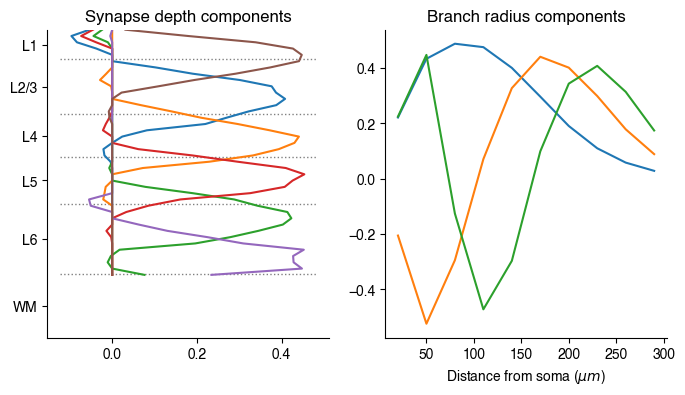

In [5]:
rawi_df = fc.io_utils.load_features(i_oids, feature_dir)
(
    feat_df,
    feat_cols,
    syn_pca,
    br_svd,
    keep_depth,
    ego_pca,
) = fc.assembly.assemble_features_from_data(rawi_df, n_syn_comp=6, n_branch_comp=3)

radius_bins = fc.extraction.radius_bins
depth_bins = fc.extraction.make_depth_bins(height_bounds, 50)

fig, axes = plt.subplots(ncols=2, figsize=(8, 4), facecolor="w")
ax = axes[0]
ax.plot(syn_pca.components_.T, depth_bins[:-1][keep_depth])
plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    ax.get_xlim(),
    color=(0.5, 0.5, 0.5),
    linewidth=1,
    linestyle=":",
    ax=ax,
)
sns.despine(ax=ax)
ax.set_title("Synapse depth components")

ax = axes[1]
ax.plot(radius_bins, br_svd.components_.T)
sns.despine(ax=ax)
ax.set_title("Branch radius components")
_ = ax.set_xlabel("Distance from soma ($\mu m$)")

In [6]:
col_syn_df = pd.read_feather(
    f"{project_paths.data}/temp/baseline_synapses_slanted_update_v{version}_post.feather"
)

In [7]:
import tqdm


def get_pre_df(root_id):
    fname = f"{project_paths.skeletons}/skeleton_files/{root_id}.h5"
    nrn = meshwork.load_meshwork(fname)
    return nrn.anno.pre_syn.df.drop(columns=["post_pt_root_id", "pre_pt_level2_id"])


def get_pre_dfs(root_ids):
    df = []
    for root_id in tqdm.tqdm(root_ids):
        df.append(get_pre_df(root_id))
    return pd.concat(df, ignore_index=False)


def get_i_to_column_df(root_ids, environ, version, prox_threshold=50):
    pre_df = get_pre_dfs(root_ids)

    col_syn_df = pd.read_feather(
        f"{project_paths.data}/temp/baseline_synapses_{environ}_v{version}_post.feather"
    )
    col_syn_df["is_proximal"] = col_syn_df["dist_to_root"] < prox_threshold + 15
    return pre_df.merge(
        col_syn_df[
            [
                "id",
                "post_pt_root_id",
                "dist_to_root",
                "is_apical",
                "is_soma",
                "is_dendrite",
                "is_proximal",
                "syn_depth_um",
                "soma_depth_um",
                "valence",
            ]
        ],
        on="id",
        how="inner",
    )

In [8]:
syn_i_df = get_i_to_column_df(i_oids, "slanted_update", version)

100%|█████████████████████████████████████████| 164/164 [00:23<00:00,  7.12it/s]


In [ ]:
i_syn_all = get_pre_dfs(i_oids)

In [9]:
baseline_df = pd.read_feather('baseline_comp_v795.feather')

baseline_df.sum().sum()

syn_i_df.groupby('valence').count()

,ctr_pt_position,id,post_pt_position,post_pt_supervoxel_id,pre_pt_mesh_ind,pre_pt_position,pre_pt_root_id,pre_pt_supervoxel_id,size,pre_pt_mesh_ind_filt,post_pt_root_id,dist_to_root,is_apical,is_soma,is_dendrite,is_proximal,syn_depth_um,soma_depth_um
valence,,,,,,,,,,,,,,,,,,
Exc,70898,70898,70898,70898,70898,70898,70898,70898,70898,70898,70898,70898,70898,70898,70898,70898,70898,70898
Inh,9235,9235,9235,9235,9235,9235,9235,9235,9235,9235,9235,9235,9235,9235,9235,9235,9235,9235


In [ ]:
timestamp

In [10]:
syn_ii_df = syn_i_df.query('valence=="Inh"')

In [11]:
syn_ii_df['post_pt_root_id'] = client.chunkedgraph.get_roots(
    syn_ii_df['post_pt_supervoxel_id'],
    timestamp=timestamp,
)

/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_99676/1747106315.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syn_ii_df['post_pt_root_id'] = client.chunkedgraph.get_roots(


In [12]:
syn_ii_df.groupby(['pre_pt_root_id', 'post_pt_root_id']).count()

ctr_pt_position  id  post_pt_position  \
pre_pt_root_id     post_pt_root_id                                             
864691134886015738 864691135502190941                1   1                 1   
                   864691135654475970                1   1                 1   
                   864691135816038479                1   1                 1   
864691134886016762 864691135013445270                5   5                 5   
                   864691135082840567                9   9                 9   
...                                                ...  ..               ...   
864691137197468481 864691136275240461                1   1                 1   
                   864691136452054015                2   2                 2   
                   864691136618908301                1   1                 1   
                   864691136662432990                3   3                 3   
                   864691136912943345               15  15                15   

                                       post_pt_supervoxel_id  pre_pt_mesh_ind  \
pre_pt_root_id     post_pt_root_id                                              
864691134886015738 864691135502190941                      1                1   
                   864691135654475970                      1                1   
                   864691135816038479                      1                1   
864691134886016762 864691135013445270                      5                5   
                   864691135082840567                      9                9   
...                                                      ...              ...   
864691137197468481 864691136275240461                      1                1   
                   864691136452054015                      2                2   
                   864691136618908301                      1                1   
                   864691136662432990                      3                3   
                   864691136912943345                     15               15   

                                       pre_pt_position  pre_pt_supervoxel_id  \
pre_pt_root_id     post_pt_root_id                                             
864691134886015738 864691135502190941                1                     1   
                   864691135654475970                1                     1   
                   864691135816038479                1                     1   
864691134886016762 864691135013445270                5                     5   
                   864691135082840567                9                     9   
...                                                ...                   ...   
864691137197468481 864691136275240461                1                     1   
                   864691136452054015                2                     2   
                   864691136618908301                1                     1   
                   864691136662432990                3                     3   
                   864691136912943345               15                    15   

                                       size  pre_pt_mesh_ind_filt  \
pre_pt_root_id     post_pt_root_id                                  
864691134886015738 864691135502190941     1                     1   
                   864691135654475970     1                     1   
                   864691135816038479     1                     1   
864691134886016762 864691135013445270     5                     5   
                   864691135082840567     9                     9   
...                                     ...                   ...   
864691137197468481 864691136275240461     1                     1   
                   864691136452054015     2                     2   
                   864691136618908301     1                     1   
                   864691136662432990     3                     3   
                   864691136912943345    15                    15   

     

In [13]:
from standard_transform import minnie_ds

In [14]:
tform = minnie_ds.transform_vx
tform_nm = minnie_ds.transform_nm

In [15]:
ct_df['soma_depth'] = tform.apply_project('y', ct_df['pt_position'])

In [16]:
syn_i_df_ct = (
    syn_i_df.merge(
        ct_df[["pt_root_id", 'cell_type']],
        left_on="pre_pt_root_id",
        right_on="pt_root_id",
        how="left",
    )
    .drop(columns="pt_root_id")
    .rename(columns={"cell_type": "cell_type_pre"})
)

syn_i_df_ct['syn_in_conn'] = syn_i_df_ct.groupby(['pre_pt_root_id', 'post_pt_root_id'])['id'].transform('count')
syn_i_df_ct['is_multisyn'] = syn_i_df_ct['syn_in_conn'] > 1

In [17]:
from scipy import sparse

In [18]:
clump_dfs = []

for root_id in tqdm.tqdm(i_oids):
    nrn = fc.io_utils.load_root_id(root_id, project_paths, peel_threshold=None)
    presyn_df = syn_i_df_ct.query('pre_pt_root_id == @root_id')
    if len(presyn_df)==0:
        continue
        
    m_targ = np.tile(
        np.atleast_2d(presyn_df['post_pt_root_id'].values).T,
        len(presyn_df),
    )
    same_targ = m_targ==m_targ.T

    d_syn = nrn.distance_between(presyn_df['pre_pt_mesh_ind'], presyn_df['pre_pt_mesh_ind'])/1_000

    G = np.logical_and(same_targ, d_syn < 15).astype(int) - np.eye(len(presyn_df))
    Gs = sparse.csr_matrix(G)
    _, syn_comp = sparse.csgraph.connected_components(Gs)

    d_syn[
        np.diag_indices(d_syn.shape[0])
    ] = np.inf
    d_syn[~same_targ] = np.inf
    dmin = np.min(d_syn, axis=0)

    presyn_df['syn_clump_comp'] = syn_comp
    presyn_df['syn_in_clump'] = presyn_df.groupby('syn_clump_comp')['id'].transform('count')
    presyn_df['is_clumped'] = presyn_df['syn_in_clump'] > 1 

    presyn_df['closest_same'] = dmin
    clump_dfs.append( presyn_df[['syn_clump_comp', 'syn_in_clump', 'is_clumped', 'closest_same']] )

  0%|                                                   | 0/164 [00:00<?, ?it/s]/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_99676/2927930579.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  presyn_df['syn_clump_comp'] = syn_comp
/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_99676/2927930579.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  presyn_df['syn_in_clump'] = presyn_df.groupby('syn_clump_comp')['id'].transform('count')
/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn

In [ ]:
clump_dfs_5 = []
clump_dfs_10 = []
clump_dfs_15 = []
clump_dfs_20 = []
clump_dfs_25 = []
clump_dfs_30 = []

cdfs = {
    5: clump_dfs_5,
    10: clump_dfs_10,
    15: clump_dfs_15,
    20: clump_dfs_20,
    25: clump_dfs_25,
    30: clump_dfs_30,
}

for root_id in tqdm.tqdm(i_oids):
    nrn = fc.io_utils.load_root_id(root_id, project_paths, peel_threshold=None)
    presyn_df = syn_i_df_ct.query("pre_pt_root_id == @root_id")
    if len(presyn_df) == 0:
        continue

    m_targ = np.tile(
        np.atleast_2d(presyn_df["post_pt_root_id"].values).T,
        len(presyn_df),
    )
    same_targ = m_targ == m_targ.T

    d_syn = (
        nrn.distance_between(presyn_df["pre_pt_mesh_ind"], presyn_df["pre_pt_mesh_ind"])
        / 1_000
    )
    dmin = np.min(d_syn, axis=0)

    for th, cdf in cdfs.items():
        pdf = presyn_df.copy()

        G = np.logical_and(same_targ, d_syn < th).astype(int) - np.eye(len(presyn_df))
        Gs = sparse.csr_matrix(G)
        _, syn_comp = sparse.csgraph.connected_components(Gs)

        pdf["syn_clump_comp"] = syn_comp
        pdf["syn_in_clump"] = pdf.groupby("syn_clump_comp")["id"].transform("count")
        pdf["is_clumped"] = pdf["syn_in_clump"] > 1
        pdf['closest_same'] = dmin

        cdf.append(
            pdf[["syn_clump_comp", "syn_in_clump", "is_clumped", "closest_same"]]
        )

In [ ]:
syn_i_df_ct = syn_i_df_ct.merge(pd.concat(clump_dfs), left_index=True, right_index=True)

i_clump_prop = (
    syn_i_df_ct.groupby(["pre_pt_root_id", "valence"])
    .agg(
        {
            "is_clumped": "mean",
            "is_multisyn": "mean",
            "cell_type_pre": lambda x: list(x)[0],
        }
    )
    .reset_index()
)

i_clump_conn_prop = (
    syn_i_df_ct.drop_duplicates(subset=['pre_pt_root_id', 'post_pt_root_id']).groupby(["pre_pt_root_id", "valence"])
    .agg(
        {
            "is_multisyn": "mean",
            "cell_type_pre": lambda x: list(x)[0],
        }
    )
    .reset_index()
    .rename(
        columns={
            'is_multisyn': 'conn_is_multisyn',
        }
    )
    .drop(columns=['cell_type_pre'])
)

i_clump_prop = i_clump_prop.merge(i_clump_conn_prop, on=['pre_pt_root_id', 'valence'])
i_clump_prop['is_clumped'] = i_clump_prop['is_clumped']/i_clump_prop['is_multisyn']

In [ ]:
syn_dist_bins = np.arange(0, 101, 2)
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)
sns.histplot(
    x="closest_same",
    hue="cell_type_pre",
    data=syn_i_df_ct.query(
        'valence == "Exc" and is_multisyn'
    ),
    ax=ax,
    bins=syn_dist_bins,
    element="step",
    common_norm=False,
    cumulative=True,
    stat="density",
    fill=False,
    # palette=ctype_hues,
)
# ax.vlines([10, 15], 0, 1, color="k", linestyle=":")

In [ ]:
ct_list_inh = ['BC', 'MC', 'NGC', 'BPC', 'Unsure I']

In [ ]:
i_clump_prop['valence'] = i_clump_prop['valence'].astype(pd.CategoricalDtype(['Exc', 'Inh'], ordered=True))
i_clump_prop['cell_type_pre'] = i_clump_prop['cell_type_pre'].astype(pd.CategoricalDtype(ct_list_inh, ordered=True))

In [ ]:
ie_palette = {'Inh': ei_palette['Exc'], 'Exc': ei_palette['Inh']}

In [ ]:
ei_palette = ie_palette.copy()

In [ ]:
fig, axes = plt.subplots(figsize=(12, 2), ncols=3, sharey=True, dpi=150)

s = 1.75
ax=axes[0]
sns.swarmplot(
    x="cell_type_pre",
    y="conn_is_multisyn",
    hue="valence",
    s=s,
    data=i_clump_prop,
    dodge=True,
    ax=ax,
    palette=ei_palette,
)
ax.set_ylabel('Frac. Conn.')
ax.legend().set_visible(False)
ax.set_title('Connections')
ax.grid(which='both', axis='y', linewidth=1, linestyle=':')

ax=axes[1]
sns.swarmplot(
    x="cell_type_pre",
    y="is_multisyn",
    hue="valence",
    s=s,
    data=i_clump_prop,
    dodge=True,
    ax=ax,
    palette=ei_palette,
)
ax.legend().set_visible(False)
ax.set_ylabel('Frac. Syn.')

ax.set_title('Synapses')
ax.grid(which='both', axis='y', linewidth=1, linestyle=':')

ax=axes[2]
sns.swarmplot(
    x="cell_type_pre",
    y="is_clumped",
    hue="valence",
    s=s,
    data=i_clump_prop,
    dodge=True,
    ax=ax,
    palette=ei_palette,
)
ax.set_ylabel('Frac. Multisyn.')
ax.set_ylim(-0.05,1.05)
ax.set_yticks(np.arange(0,1.01, 0.2))
              
ax.legend().set_visible(False)
sns.despine(ax=ax, offset=5, trim=True)
sns.despine(ax=axes[0], offset=5, trim=True)
sns.despine(ax=axes[1], offset=5, trim=True)

ax.set_title('Clumped Synapses')
ax.grid(which='both', axis='y', linewidth=1, linestyle=':')
ax.legend().set_bbox_to_anchor((1, 1))

if save_plots:
    fig.savefig(f'{plot_dir}/connection_clumpiness_manual.pdf', bbox_inches='tight')

In [ ]:
i_cl_df = i_clump_prop.pivot(columns='valence', values='is_clumped', index=['pre_pt_root_id', 'cell_type_pre']).reset_index()

In [ ]:
syn_i_df_ct["clump_in_conn"] = syn_i_df_ct.groupby(
    ["pre_pt_root_id", "post_pt_root_id"]
)["syn_clump_comp"].transform(lambda x: len(np.unique(x)))
syn_i_df_ct["syn_depth"] = tform.apply_project("y", syn_i_df_ct["ctr_pt_position"])

In [ ]:
inhib_prop_df = (
    syn_i_df.query("is_dendrite==True")
    .groupby(["pre_pt_root_id"])
    .agg({"id": "count"})
    .rename(columns={"id": "tot_out"})
)

inhib_prop_df = inhib_prop_df.merge(
    syn_i_df.query('is_dendrite==True and valence=="Inh"')
    .groupby(["pre_pt_root_id"])
    .agg({"id": "count"})
    .rename(columns={"id": "inh_out"}),
    left_index=True,
    right_index=True,
    how="left",
)

inhib_prop_df = inhib_prop_df.merge(
    syn_i_df.query('is_dendrite==True and valence=="Exc"')
    .groupby(["pre_pt_root_id"])
    .agg({"id": "count"})
    .rename(columns={"id": "exc_out"}),
    left_index=True,
    right_index=True,
    how="left",
)

inhib_prop_df = inhib_prop_df.merge(
    syn_i_df.query('is_dendrite==True and valence=="Exc" and is_apical and not is_proximal')
    .groupby(["pre_pt_root_id"])
    .agg({"id": "count"})
    .rename(columns={"id": "apical_out"}),
    left_index=True,
    right_index=True,
    how="left",
)

inhib_prop_df = inhib_prop_df.merge(
    syn_i_df.query('is_dendrite==True and valence=="Exc" and is_soma')
    .groupby(["pre_pt_root_id"])
    .agg({"id": "count"})
    .rename(columns={"id": "soma_out"}),
    left_index=True,
    right_index=True,
    how="left",
)

inhib_prop_df = inhib_prop_df.merge(
    syn_i_df.query('is_dendrite==True and valence=="Exc" and not is_soma and is_proximal')
    .groupby(["pre_pt_root_id"])
    .agg({"id": "count"})
    .rename(columns={"id": "proximal_out"}),
    left_index=True,
    right_index=True,
    how="left",
)

inhib_prop_df["frac_inh"] = inhib_prop_df["inh_out"] / inhib_prop_df["tot_out"]
inhib_prop_df["frac_apical"] = inhib_prop_df["apical_out"] / inhib_prop_df["exc_out"]
inhib_prop_df["frac_soma"] = inhib_prop_df["soma_out"] / inhib_prop_df["exc_out"]
inhib_prop_df["frac_proximal"] = (
    inhib_prop_df["proximal_out"] / inhib_prop_df["exc_out"]
)

inhib_prop_df.fillna(0, inplace=True)
inhib_prop_df = inhib_prop_df.merge(
    feat_df, left_index=True, right_on="root_id", how="left"
)

inhib_prop_df = inhib_prop_df.merge(
    ct_df[["pt_root_id", "cell_type"]],
    left_on="root_id",
    right_on="pt_root_id",
).set_index("root_id")

In [ ]:
i_clump_prop_wide = i_clump_prop.pivot_table(index='pre_pt_root_id', values=['is_clumped', 'is_multisyn', 'conn_is_multisyn'], columns=['valence'])
i_clump_prop_wide.columns = [f"{x[0]}_{x[1]}".lower() for x in i_clump_prop_wide.columns]
inhib_prop_df = inhib_prop_df.merge(i_clump_prop_wide, left_index=True, right_index=True).fillna(0)

In [ ]:
inhib_prop_df["is_multisyn_all"] = (
    inhib_prop_df["is_multisyn_exc"] * (1 - inhib_prop_df["frac_inh"])
    + inhib_prop_df["is_multisyn_inh"] * inhib_prop_df["frac_inh"]
)

inhib_prop_df["is_clumped_all"] = (
    inhib_prop_df["is_clumped_exc"] * (1 - inhib_prop_df["frac_inh"])
    + inhib_prop_df["is_clumped_inh"] * inhib_prop_df["frac_inh"]
)

In [ ]:
inhib_prop_df["is_prox_plus"] = inhib_prop_df["frac_soma"] + inhib_prop_df["frac_proximal"] 

inhib_prop_df['frac_distal'] = (1-(inhib_prop_df['frac_apical'] + inhib_prop_df['frac_soma'] + inhib_prop_df['frac_proximal']))

base_cat = ['frac_inh', 'frac_apical', 'frac_soma', 'frac_proximal', 'is_multisyn_all', 'is_clumped_all']

inhib_prop_df[base_cat]

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(solver="svd")

X = inhib_prop_df.query('cell_type != "Unsure I"')[base_cat]
y = inhib_prop_df.query('cell_type != "Unsure I"')["cell_type"]

lda.fit(X, y)
XX = lda.transform(inhib_prop_df[base_cat])

inhib_prop_df["pca0"] = XX[:, 0]
inhib_prop_df["pca1"] = XX[:, 1]
inhib_prop_df["pca2"] = XX[:, 2]

inhib_prop_df["pred_ct"] = lda.predict(inhib_prop_df[base_cat])

inhib_prop_df['pred_ct'] = inhib_prop_df['pred_ct'].replace({'BC': 'PTC', 'MC': 'DTC', 'BPC': 'ITC', 'NGC': 'STC'})

In [ ]:
inhib_prop_df.pivot_table(index='pred_ct', columns='cell_type', values='tot_out', aggfunc='count', fill_value=0).loc[['PTC', 'DTC', 'STC', 'ITC']]

In [ ]:
inhib_prop_df.reset_index().to_feather(f"{data_dir}/inhib_prop_df.feather")

In [ ]:
syn_i_df_ct = syn_i_df_ct.merge(
    inhib_prop_df[['pred_ct']],
    left_on='pre_pt_root_id',
    right_index=True,
)

In [ ]:
(
    syn_i_df_ct.query('valence == "Exc" and is_multisyn and pred_ct not in ["ITC"]')
    .groupby(["pre_pt_root_id", "cell_type_pre"])["closest_same"]
    .median()
    .reset_index()
).groupby('cell_type_pre').count()

In [ ]:
fig, ax = plt.subplots(figsize=(3, 3), dpi=300)

sns.histplot(
    x="closest_same",
    hue="cell_type_pre",
    # palette=ctype_hues,
    data=syn_i_df_ct.query('valence == "Exc" and is_multisyn and pred_ct not in ["ITC"]')
    .groupby(["pre_pt_root_id", "cell_type_pre"])["closest_same"]
    .median()
    .reset_index(),
    bins=np.arange(0, 100, 1),
    cumulative=True,
    common_norm=False,
    stat='density',
    element='step',
    fill=False,
    ax=ax,
)

ax.vlines([15], 0, 1, color="k", linestyle=":")

In [ ]:
orig_pal = {ct: clr for ct, clr in zip( ['BC', 'MC', 'NGC', 'BPC', "Unsure I"], sns.palettes.color_palette('tab10') ) }

In [ ]:
syn_dist_bins = np.append(np.arange(0, 303, 2), 1_000_000)
fig, axes = plt.subplots(figsize=(6, 2.5), ncols=2, dpi=300, sharey=True)
ax = axes[0]
sns.histplot(
    x="closest_same",
    hue="cell_type_pre",
    data=syn_i_df_ct.query(
        'valence == "Exc" and is_multisyn and cell_type_pre != "Unsure I"'
    ),
    ax=ax,
    bins=syn_dist_bins,
    element="step",
    common_norm=False,
    cumulative=True,
    stat="probability",
    fill=False,
    palette=orig_pal,
    legend=False,
)

ax.set_xlim(0, 300)
ax.vlines([15], 0, 1, color="k", linestyle="-", alpha=0.5, zorder=-10, linewidth=1)
# ax.vlines(15, 0, 1, color="k", linestyle="-", alpha=0.5, zorder=-10, linewidth=1)
sns.despine(ax=ax, offset=4, trim=True)
ax.set_xlabel("Closest same-target synapse ($\mu m$)")
ax.set_title("Excitatory targets")
ax.set_ylabel("Cumulative probability")

ax = axes[1]
sns.histplot(
    x="closest_same",
    hue="cell_type_pre",
    data=syn_i_df_ct.query(
        'valence == "Inh" and is_multisyn and cell_type_pre != "Unsure I"'
    ),
    ax=ax,
    bins=syn_dist_bins,
    element="step",
    common_norm=False,
    cumulative=True,
    stat="probability",
    fill=False,
    palette=orig_pal,
)

ax.vlines([15], 0, 1, color="k", linestyle="-", alpha=0.5, zorder=-10, linewidth=1)
ax.set_xlim(0, 300)
sns.despine(ax=ax, offset=4, trim=True)
ax.set_xlabel("Closest same-target synapse ($\mu m$)")
ax.set_title("Inhibitory targets")

fig.savefig(f'{plot_dir}/closest_syn_manual_types.pdf', bbox_inches='tight')

In [ ]:
syn_dist_bins = np.append(np.arange(0, 303, 2), 1_000_000)
fig, axes = plt.subplots(figsize=(6, 2.5), ncols=2, dpi=300, sharey=True)
ax = axes[0]
sns.histplot(
    x="closest_same",
    hue="pred_ct",
    data=syn_i_df_ct.query(
        'valence == "Exc" and is_multisyn'
    ),
    ax=ax,
    bins=syn_dist_bins,
    element="step",
    common_norm=False,
    cumulative=True,
    stat="probability",
    fill=False,
    palette=ctype_hues,
    legend=False,
)

ax.vlines(15, 0, 1, color="k", linestyle="-", alpha=0.5, zorder=-10, linewidth=1)
ax.set_xlim(1,300)
ax.set_xticks([1,5,10,50,100,200,300])
ax.set_xscale('log')

sns.despine(ax=ax, offset=4)
ax.set_xlabel('Closest same-target synapse ($\mu m$)')
ax.set_title('Excitatory targets')
ax.set_ylabel('Cumulative probability')

ax = axes[1]
sns.histplot(
    x="closest_same",
    hue="pred_ct",
    data=syn_i_df_ct.query(
        'valence == "Inh" and is_multisyn'
    ),
    ax=ax,
    bins=syn_dist_bins,
    element="step",
    common_norm=False,
    cumulative=True,
    stat="probability",
    fill=False,
    palette=ctype_hues,
)

ax.vlines(15, 0, 1, color="k", linestyle="-", alpha=0.5, zorder=-10, linewidth=1)
ax.set_xlim(1,300)
ax.set_xticks([1,5,10,50,100,200,300])
ax.set_xscale('log')

sns.despine(ax=ax, offset=4)
ax.set_xlabel('Closest same-target synapse ($\mu m$)')
ax.set_title('Inhibitory targets')
fig.savefig(f'{plot_dir}/closest_syn_lda_types.pdf', bbox_inches='tight')

In [ ]:
syn_i_df_ct_temp = (
    syn_i_df.merge(
        ct_df[["pt_root_id", 'cell_type']],
        left_on="pre_pt_root_id",
        right_on="pt_root_id",
        how="left",
    )
    .drop(columns="pt_root_id")
    .rename(columns={"cell_type": "cell_type_pre"})
)

syn_i_df_ct_temp['syn_in_conn'] = syn_i_df_ct_temp.groupby(['pre_pt_root_id', 'post_pt_root_id'])['id'].transform('count')
syn_i_df_ct_temp['is_multisyn'] = syn_i_df_ct_temp['syn_in_conn'] > 1

In [ ]:
i_clump_prop_test = i_clump_prop.copy().set_index(['pre_pt_root_id'])

for th, cdf in cdfs.items():
    sdt = syn_i_df_ct_temp.merge(
        pd.concat(cdf),
        left_index=True,
        right_index=True,
    ).groupby(['pre_pt_root_id']).agg(
        {
            "is_clumped": "mean",
        }
    )
    i_clump_prop_test[f"is_clumped_{th}"] = sdt['is_clumped']

i_clump_prop_test = i_clump_prop_test.reset_index()

i_clump_prop_test = i_clump_prop_test.merge(
    inhib_prop_df['pred_ct'],
    left_on='pre_pt_root_id',
    right_index=True,
)

In [ ]:
i_clump_prop_test['pred_ct'] = i_clump_prop_test['pred_ct'].astype(
    pd.CategoricalDtype(["PTC", "DTC", "STC", "ITC"], ordered=True)
)

In [ ]:
fig, axes = plt.subplots(
    figsize=(3 * len(cdfs), 2),
    ncols=len(cdfs),
    sharey=True,
)
for ax, th in zip(axes, cdfs):
    sns.stripplot(
        x="cell_type_pre",
        y=f"is_clumped_{th}",
        hue="cell_type_pre",
        palette=orig_pal,
        data=i_clump_prop_test,
        jitter=0.3,
        alpha=0.2,
        legend=False,
        ax=ax,
        zorder=-10,
    )

    sns.pointplot(
        x="cell_type_pre",
        y=f"is_clumped_{th}",
        color="k",
        estimator="median",
        data=i_clump_prop_test,
        ax=ax,
        join=False,
    )
    sns.despine(ax=ax)
    ax.set_title(f'{th} $\mu m$')
    ax.set_xlabel('')
    
axes[0].set_ylabel('Fraction synapses')
fig.savefig(f"{plot_dir}/clumped_comparison_across_distances_manual.pdf")

In [ ]:
fig, axes = plt.subplots(
    figsize=(3 * len(cdfs), 2),
    ncols=len(cdfs),
    sharey=True,
)

for ax, th in zip(axes, cdfs):
    sns.stripplot(
        x="pred_ct",
        y=f"is_clumped_{th}",
        hue="pred_ct",
        palette=ctype_hues,
        data=i_clump_prop_test,
        jitter=0.3,
        alpha=0.2,
        legend=False,
        ax=ax,
        zorder=-10,
    )

    sns.pointplot(
        x="pred_ct",
        y=f"is_clumped_{th}",
        color="k",
        estimator="median",
        data=i_clump_prop_test,
        ax=ax,
        join=False,
    )
    sns.despine(ax=ax)
    ax.set_title(f"{th} $\mu m$")
    ax.set_xlabel('')
    
axes[0].set_ylabel('Fraction synapses')
fig.savefig(f"{plot_dir}/clumped_comparison_across_distances")

In [ ]:
# syn_i_df_ct = syn_i_df_ct.merge(pd.concat(clump_dfs), left_index=True, right_index=True)

i_clump_prop = (
    syn_i_df_ct.groupby(["pre_pt_root_id", "valence"])
    .agg(
        {
            "is_clumped": "mean",
            "is_multisyn": "mean",
            "cell_type_pre": lambda x: list(x)[0],
        }
    )
    .reset_index()
)

In [ ]:
feat_cols

In [ ]:
feat_cols_nospace = [
    "tip_len_dist_dendrite_p50",
    "tip_tort_dendrite_p50",
    "num_syn_dendrite",
    "num_syn_soma",
    "path_length_dendrite",
    "radial_extent_dendrite",
    "syn_dist_distribution_dendrite_p50",
    "syn_size_distribution_soma_p50",
    "syn_size_distribution_dendrite_p50",
    "syn_size_distribution_dendrite_dyn_range",
    # "syn_depth_dist_p5",
    # "syn_depth_dist_p95",
    "syn_depth_extent",
    "max_density",
    "radius_dist",
    'ego_count_pca0',
 'ego_count_pca1',
 'ego_count_pca2',
 'ego_count_pca3',
 'ego_count_pca4'
]

In [ ]:
feat_cols_i = feat_cols_nospace + base_cat
datz = stats.zscore(inhib_prop_df[feat_cols_i].values)

X = umap.UMAP(n_neighbors=10, metric="euclidean", min_dist=0.1).fit_transform(datz)

inhib_prop_df["umap0"] = X[:, 0]
inhib_prop_df["umap1"] = X[:, 1]

fig, ax = plt.subplots(figsize=(3, 3), dpi=150)
sns.scatterplot(
    x="umap0",
    y="umap1",
    data=inhib_prop_df,
    hue="pred_ct",
    palette="Dark2",
    ax=ax,
    s=20,
    alpha=0.7,
)
ax.legend().set_bbox_to_anchor((1, 1))

In [ ]:
inhib_prop_df.query('cell_type == "Unsure I"')

In [ ]:
fig, axes = plt.subplots(figsize=(8,4), ncols=2, sharey=True, dpi=150)

ax=axes[0]
# sns.scatterplot(
#     x='pca1',
#     y='pca0',
#     data=inhib_prop_df.query('cell_type != "Unsure I"'),
#     hue='pred_ct',
#     palette=ctype_hues,
#     ax=ax,
#     legend=False,
#     alpha=0.7
# )

sns.scatterplot(
    x='pca1',
    y='pca0',
    data=inhib_prop_df.query('cell_type == "Unsure I"'),
    palette=ctype_hues,
    fc=(0.8, 0.8, 0.8),
    ec=inhib_prop_df.query('cell_type=="Unsure I"')['pred_ct'].map(ctype_hues),
    ax=ax,
    legend=False,
)


In [ ]:
fig, axes = plt.subplots(figsize=(8,4), ncols=2, sharey=True, dpi=150)

ax=axes[0]
sns.scatterplot(
    x='pca1',
    y='pca0',
    data=inhib_prop_df.query('cell_type != "Unsure I"'),
    hue='pred_ct',
    palette=ctype_hues,
    ax=ax,
    legend=False,
    alpha=0.7
)

sns.scatterplot(
    x='pca1',
    y='pca0',
    data=inhib_prop_df.query('cell_type == "Unsure I"'),
    palette=ctype_hues,
    fc=(0.8, 0.8, 0.8),
    ec=inhib_prop_df.query('cell_type=="Unsure I"')['pred_ct'].map(ctype_hues),
    ax=ax,
    legend=False,
)

ax.set_xlabel('LD1')
ax.set_ylabel('LD0')
sns.despine(ax=ax)


ax=axes[1]
sns.scatterplot(
    x='pca2',
    y='pca0',
    data=inhib_prop_df.query('cell_type != "Unsure I"'),
    hue='pred_ct',
    palette=ctype_hues,
    ax=ax,
    legend=False,
    alpha=0.7
)

sns.scatterplot(
    x='pca2',
    y='pca0',
    data=inhib_prop_df.query('cell_type == "Unsure I"'),
    palette=ctype_hues,
    fc=(0.8, 0.8, 0.8),
    ec=inhib_prop_df.query('cell_type=="Unsure I"')['pred_ct'].map(ctype_hues),
    ax=ax,
    legend=False,
)


ax.set_xlabel('LD2')
ax.set_ylabel('LD0')
sns.despine(ax=ax)

if save_plots:
    plt.savefig(f'{plot_dir}/lda_inhib_subclasses.pdf', bbox_inches='tight')
    

In [ ]:
inhib_prop_df.query('pca0 < -2 and pred_ct == "DTC"')

In [ ]:
inhib_manual_df = inhib_prop_df.pivot_table(
    values='frac_inh',
    index='cell_type',
    columns='pred_ct',
    aggfunc='count',
    fill_value=0,
)

fig, ax = plt.subplots(figsize=(4,4), dpi=150)
sns.heatmap(
    inhib_manual_df.loc[['BC', 'MC', 'NGC', 'BPC', 'Unsure I']][['PTC', 'DTC', 'STC', 'ITC']].T,
    cmap='viridis',
    annot=True,
    square=True,
    cbar=None,
)

ax.set_xlabel('Manual Cell Type')
ax.set_ylabel('Feature-based Cell Type')
if save_plots:
    fig.savefig(f"{plot_dir}/inhib_manual_vs_features.pdf", bbox_inches='tight')

In [ ]:
i_ct_df = ct_df.merge(
    inhib_prop_df.reset_index()[['pt_root_id', 'pred_ct']],
    on='pt_root_id',
)

e_ct_df = ct_df.merge(
    dfct_e[['root_id', 'hlabel']].rename(columns={'root_id': 'pt_root_id', 'hlabel':'pred_ct'}),
    on='pt_root_id',
)

new_ct_df = pd.concat([e_ct_df, i_ct_df])

ct_list_exc = dfct_e.hlabel.dtype.categories.values
ct_list_inh = ['PTC', 'DTC', 'STC', 'ITC']

(
    new_ct_df[["pt_root_id", "classification_system", 'pt_position', "pred_ct"]].rename(
        columns={"pred_ct": "cell_type"}
    )
).to_pickle("hlabel_types.pkl")

import pickle

with open("etypes_consensus.pkl", "wb") as f:
    pickle.dump(list(ct_list_exc), f)

with open("itypes_consensus.pkl", "wb") as f:
    pickle.dump(list(ct_list_inh), f)

In [ ]:
np.save(f'i_oids_v{version}.npy', i_oids)

In [ ]:
dfct_e.to_feather('dfct_e.feather')

In [ ]:
np.save(f'i_oids_v{version}.npy', i_oids)

```bash
ALTERNATE_E_TYPES=/Users/caseysm/Work/Projects/MinnieColumn/notebooks/etypes_consensus.pkl
ALTERNATE_I_TYPES=/Users/caseysm/Work/Projects/MinnieColumn/notebooks/itypes_consensus.pkl
ALTERNATE_CELL_TYPE=/Users/caseysm/Work/Projects/MinnieColumn/notebooks/hlabel_types.pkl
```

---
Save to data directory for downstream processing

In [ ]:
(
    new_ct_df[["pt_root_id", "classification_system", 'pt_position', "pred_ct"]].rename(
        columns={"pred_ct": "cell_type"}
    )
).to_pickle(f"{data_dir}/hlabel_types.pkl")

import pickle

with open(f"{data_dir}/etypes_consensus.pkl", "wb") as f:
    pickle.dump(list(ct_list_exc), f)

with open(f"{data_dir}/itypes_consensus.pkl", "wb") as f:
    pickle.dump(list(ct_list_inh), f)
    
np.save(f'{data_dir}/i_oids_v{client.materialize.version}.npy', i_oids)

syn_i_df_ct.to_feather(f"{data_dir}/syn_i_df.feather")
dfct_e.to_feather(f"{data_dir}/dfct_e.feather")

In [ ]:
with open(f"{data_dir}/ctype_hues.pkl", 'wb') as f:
    pickle.dump(ctype_hues, f)

---

In [ ]:
from caveclient import CAVEclient

client = CAVEclient('minnie65_phase3_v1')

In [ ]:
raw_df = fc.io_utils.load_features(all_oids, feature_dir)
(
    feat_df,
    feat_cols,
    syn_pca,
    br_svd,
    keep_depth,
    ego_pca,
) = fc.assembly.assemble_features_from_data(raw_df, n_syn_comp=6, n_branch_comp=3, n_syn_ego=5)
# feat_cols += ["has_ct_axon"]

In [ ]:
dfct_all = feat_df.merge(
    ct_df[["pt_root_id", "classification_system", "cell_type"]],
    left_on="root_id",
    right_on="pt_root_id",
    how="left",
)

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


In [ ]:
dat = dfct_all[feat_cols].values
datz = stats.zscore(dat)

res = umap.UMAP(metric="euclidean", n_neighbors=20)
xx = res.fit_transform(datz)
dfct_all["umap0_raw"] = xx[:, 0]
dfct_all["umap1_raw"] = xx[:, 1]

fig, ax = plt.subplots(dpi=150)

sns.scatterplot(
    x=f"umap0_raw",
    y=f"umap1_raw",
    data=dfct_all,
    hue="classification_system",
    palette="deep",
    s=8,
)

ax.legend().set_bbox_to_anchor((1, 1))
ax.set_aspect("equal")
sns.despine(ax=ax, offset=4, trim=True)
ax.set_xlabel("UMAP-0")
ax.set_ylabel("UMAP-1")

In [ ]:
dat = dfct_all[feat_cols].values
datz = stats.zscore(dat)

res = umap.UMAP(metric="euclidean", n_neighbors=20)
X = res.fit_transform(datz)

range_n_clusters = np.arange(2,15)

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(datz)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(datz, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(datz, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        xx[:, 0], xx[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()


In [ ]:
feat_cols_noct = ['tip_len_dist_dendrite_p50',
 'tip_tort_dendrite_p50',
 'num_syn_dendrite',
 'num_syn_soma',
 'path_length_dendrite',
 'radial_extent_dendrite',
 'syn_dist_distribution_dendrite_p50',
 'syn_size_distribution_soma_p50',
 'syn_size_distribution_dendrite_p50',
 'syn_size_distribution_dendrite_dyn_range',
 'syn_depth_dist_p5',
 'syn_depth_dist_p95',
 'syn_depth_extent',
 'max_density',
 'radius_dist',
 'syn_count_pca0',
 'syn_count_pca1',
 'syn_count_pca2',
 'syn_count_pca3',
 'syn_count_pca4',
 'syn_count_pca5',
 'branch_svd0',
 'branch_svd1',
 'branch_svd2',
 'ego_count_pca0',
 'ego_count_pca1',
 'ego_count_pca2',
 'ego_count_pca3',
 'ego_count_pca4',
 ]

In [ ]:
dfct_e_noct = dfct_e.copy()
dat = dfct_e_noct[feat_cols_noct].values
datz = stats.zscore(dat)

res = umap.UMAP(metric="euclidean", n_neighbors=25)
xx = res.fit_transform(datz)
dfct_e_noct["umap0_raw"] = xx[:, 0]
dfct_e_noct["umap1_raw"] = xx[:, 1]

fig, ax = plt.subplots(dpi=150)

dfct_e_noct["cell_type"] = dfct_e_noct["cell_type"].astype(
    pd.CategoricalDtype(manual_e_types, ordered=True)
)

sns.scatterplot(
    x=f"umap0_raw",
    y=f"umap1_raw",
    data=dfct_e_noct,
    hue="cell_type",
    palette="deep",
    s=8,
)

ax.legend().set_bbox_to_anchor((1, 1))
ax.set_aspect("equal")
sns.despine(ax=ax, offset=4, trim=True)
ax.set_xlabel("UMAP-0")
ax.set_ylabel("UMAP-1")
fig.savefig(f"{plot_dir}/manual_labels_umap_no_ct_feature.pdf", bbox_inches="tight")

In [ ]:
feat_cols_nospace = [
    "tip_len_dist_dendrite_p50",
    "tip_tort_dendrite_p50",
    "num_syn_dendrite",
    "num_syn_soma",
    "path_length_dendrite",
    "radial_extent_dendrite",
    "syn_dist_distribution_dendrite_p50",
    "syn_size_distribution_soma_p50",
    "syn_size_distribution_dendrite_p50",
    "syn_size_distribution_dendrite_dyn_range",
    "max_density",
    "radius_dist",
    "branch_svd0",
    "branch_svd1",
    "branch_svd2",
     'ego_count_pca0',
     'ego_count_pca1',
     'ego_count_pca2',
     'ego_count_pca3',
     'ego_count_pca4',
]

In [ ]:
dfct_e_nospace = dfct_e.copy()
dat = dfct_e_nospace[feat_cols_nospace].values
datz = stats.zscore(dat)

res = umap.UMAP(metric="euclidean", n_neighbors=25,)
xx = res.fit_transform(datz)
dfct_e_nospace["umap0_raw"] = xx[:, 0]
dfct_e_nospace["umap1_raw"] = xx[:, 1]


dfct_e_nospace["cell_type"] = dfct_e_nospace["cell_type"].astype(
    pd.CategoricalDtype(manual_e_types, ordered=True)
)

fig, ax = plt.subplots(dpi=150)

sns.scatterplot(
    x=f"umap0_raw",
    y=f"umap1_raw",
    data=dfct_e_nospace,
    hue="cell_type",
    palette="deep",
    s=8,
    ax=ax,
)

ax.legend().set_bbox_to_anchor((1, 1))
ax.set_aspect("equal")
sns.despine(ax=ax, offset=4, trim=True)
ax.set_xlabel("UMAP-0")
ax.set_ylabel("UMAP-1")

fig.savefig(
    f"{plot_dir}/manual_labels_umap_no_absolute_space_feature.pdf", bbox_inches="tight"
)

---

In [ ]:
client_new = CAVEclient('minnie65_phase3_v1')

In [ ]:
df_mat = client_new.materialize.query_table('functional_coreg', timestamp=client_new.materialize.get_timestamp(version))

oracle score
orientation tunings

In [ ]:
df_mat = df_mat.merge(
    dfct_e[["hlabel", "root_id"]], left_on="pt_root_id", right_on="root_id"
).sort_values(by=['session', 'scan_idx', 'unit_id'])

In [ ]:
df_mat.drop(columns=['hlabel', 'root_id', 'valid']).reset_index(drop=True).to_feather(f'{data_dir}/func_match_s.feather')

In [ ]:
ts = client.materialize.get_timestamp()

In [ ]:
client.chunkedgraph.get_roots(
    i_syn_all.post_pt_supervoxel_id,
    

In [ ]:
i_syn_all

----

In [ ]:
dfct_e

In [ ]:
i_oids.shape

In [ ]:
len(feat_cols)

In [ ]:
syn_i_df

In [ ]:
import pandas as pd

In [ ]:
inhib_prop_df = pd.read_feather('paper_versions/v795/data/inhib_prop_df.feather')

In [ ]:
inhib_prop_df.columns

In [ ]:
inhib_prop_df.groupby('pred_ct').frac_soma.mean()

In [ ]:
inhib_prop_df.groupby('pred_ct').frac_proximal.mean()